# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

# magic word for producing visualizations in notebook
%matplotlib inline

from sklearn.decomposition import PCA

## Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
azdias.isnull().sum().head(20)

AGER_TYP                    0
ALTERSKATEGORIE_GROB        0
ANREDE_KZ                   0
CJT_GESAMTTYP            4854
FINANZ_MINIMALIST           0
FINANZ_SPARER               0
FINANZ_VORSORGER            0
FINANZ_ANLEGER              0
FINANZ_UNAUFFAELLIGER       0
FINANZ_HAUSBAUER            0
FINANZTYP                   0
GEBURTSJAHR                 0
GFK_URLAUBERTYP          4854
GREEN_AVANTGARDE            0
HEALTH_TYP                  0
LP_LEBENSPHASE_FEIN      4854
LP_LEBENSPHASE_GROB      4854
LP_FAMILIE_FEIN          4854
LP_FAMILIE_GROB          4854
LP_STATUS_FEIN           4854
dtype: int64

In [5]:
print('Number of rows (samples):', azdias.shape[0])
print('Number of columns:', azdias.shape[1])

Number of rows (samples): 891221
Number of columns: 85


In [6]:
azdias.columns

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

In [7]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`.

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

Check if the attributes in feat.info are in the same order as in the features in azdias.


In [8]:
azdias_features = list(azdias.columns)
feat_info_attribute = list(feat_info.attribute)
list(set(azdias_features) - set(feat_info_attribute))

[]

They are in the same order. 

In [9]:
# Identify missing or unknown data values and convert them to NaNs.
azdias_features = list(azdias.columns)

**Background**

In [10]:
# First element in AGER_TYP
print(azdias[azdias_features[0]].iloc[0])
# Take missing_or_unknown from feat_info
print(feat_info.loc[0].missing_or_unknown)

-1
[-1,0]


We need to check if -1 is in [-1,0]. 
- Step 1: First remove [ and ] and split the string, this gives an list. 
- Step 2: Check if -1 is in the list.

In [11]:
# Remove [ and ], and split
mylist = feat_info.loc[0].missing_or_unknown[1:-1].split(',')
mylist

['-1', '0']

In [12]:
# Check if element is in the list
#azdias[azdias_features[0]].isin(mylist)

**---**

In [13]:
i = 0
for element in azdias_features:
    # Build a list remove [ and ], and split
    mylist = feat_info.loc[i].missing_or_unknown[1:-1].split(',')
    # make a df with True and False, the True needs to be replaced by NaN
    df = azdias[azdias_features[i]].isin(mylist)
    azdias[element] = azdias[element].where(df == False)
    i=i+1

In [14]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [15]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
tot_NaN_each_column = azdias.isnull().sum()
tot_nmb_of_samples = azdias.shape[0]
perc_feature = 100*(tot_NaN_each_column/tot_nmb_of_samples)

In [16]:
df1 = perc_feature.sort_values(ascending=False)
df1.head(15)

TITEL_KZ          99.757636
AGER_TYP          76.955435
KK_KUNDENTYP      65.596749
KBA05_BAUMAX      53.468668
GEBURTSJAHR       44.020282
ALTER_HH          34.813699
REGIOTYP          17.735668
KKK               17.735668
W_KEIT_KIND_HH    16.605084
KBA05_ANTG4       14.959701
KBA05_GBZ         14.959701
MOBI_REGIO        14.959701
KBA05_ANTG1       14.959701
KBA05_ANTG2       14.959701
KBA05_ANTG3       14.959701
dtype: float64

In [17]:
# Number of feature no missing data
print('The number of features with no missing data:', df1[df1 ==0 ].count())

The number of features with no missing data: 24


In [18]:
delta = np.linspace(5,50,10)
print('total number of feature:',azdias.shape[1])
for element in delta:
    print('Number of feature which has more than', int(element), '% Nan:', df1[df1 > int(element) ].count())

total number of feature: 85
Number of feature which has more than 5 % Nan: 53
Number of feature which has more than 10 % Nan: 46
Number of feature which has more than 15 % Nan: 9
Number of feature which has more than 20 % Nan: 6
Number of feature which has more than 25 % Nan: 6
Number of feature which has more than 30 % Nan: 6
Number of feature which has more than 35 % Nan: 5
Number of feature which has more than 40 % Nan: 5
Number of feature which has more than 45 % Nan: 4
Number of feature which has more than 50 % Nan: 4


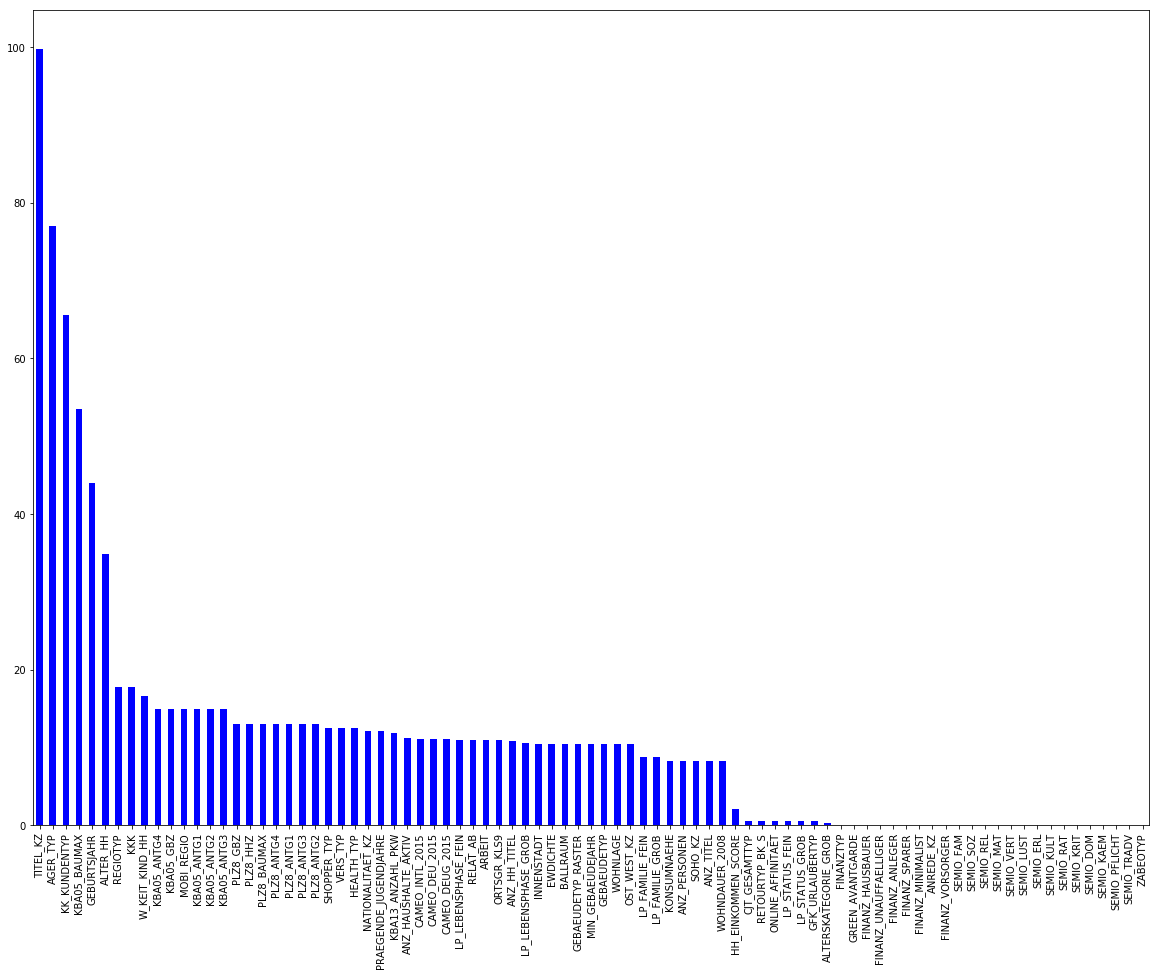

In [19]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize=(20,15))
df1.plot.bar(color='blue');

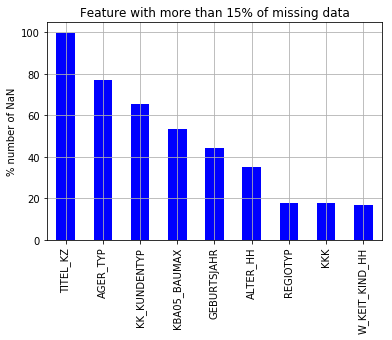

In [20]:
df1[df1 > 15].plot.bar(color='blue');
plt.ylabel('% number of NaN')
plt.title('Feature with more than 15% of missing data')
plt.grid()

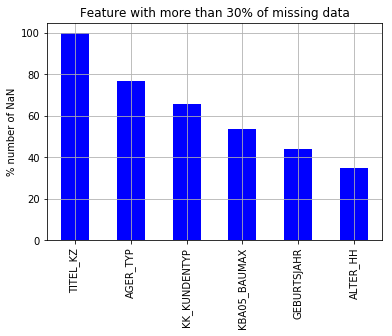

In [21]:
df1[df1 > 30].plot.bar(color='blue');
plt.title('Feature with more than 30% of missing data')
plt.ylabel('% number of NaN')
plt.grid()

**Information level**

In [22]:
information_level = []
for element in df1[df1>20].index.values:
    print(element)
    print(feat_info.information_level[feat_info.attribute == element])
    information_level.append(feat_info.information_level[feat_info.attribute == element].values[0])
df = pd.DataFrame(information_level, columns = ['information'])
df.information.value_counts()

TITEL_KZ
40    person
Name: information_level, dtype: object
AGER_TYP
0    person
Name: information_level, dtype: object
KK_KUNDENTYP
47    household
Name: information_level, dtype: object
KBA05_BAUMAX
64    microcell_rr3
Name: information_level, dtype: object
GEBURTSJAHR
11    person
Name: information_level, dtype: object
ALTER_HH
43    household
Name: information_level, dtype: object


person           3
household        2
microcell_rr3    1
Name: information, dtype: int64

In [23]:
feat_info.information_level.value_counts()

person            43
macrocell_plz8     8
household          7
building           7
microcell_rr3      6
region_rr1         5
community          3
microcell_rr4      3
postcode           3
Name: information_level, dtype: int64

**KK_KUNDENTYP** 

In [24]:
100*azdias.KK_KUNDENTYP.value_counts()/azdias.KK_KUNDENTYP.value_counts().sum()

3.0    21.248887
2.0    20.405141
5.0    15.667511
4.0    14.517513
6.0    14.387706
1.0    13.773242
Name: KK_KUNDENTYP, dtype: float64

**New dataset**

In [25]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
print(df1[df1>30].index.values)

['TITEL_KZ' 'AGER_TYP' 'KK_KUNDENTYP' 'KBA05_BAUMAX' 'GEBURTSJAHR'
 'ALTER_HH']


In [26]:
# New
azdias = azdias.drop(columns=df1[df1>30].index.values)
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [27]:
print('Number of rows (samples):', azdias.shape[0])
print('Number of columns:', azdias.shape[1])

Number of rows (samples): 891221
Number of columns: 79


#### Discussion 1.1.2: Assess Missing Data in Each Column

During exploration we observe that most of the features have missing data. Only 24 features or 28% of the 86 have no missing data. The majority of the features have between 10% and 20% mising data. Only 6 features have more than 30% of missing data. These feature are: TITEL_KZ, AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX,GEBURTSJAHR,ALTER_HH.

The question is, can these features be removed without loss of information. We must take into considuration that the dataset most be as accurate as possible for futher analyse.

Let's take a look of the meaning of the different features.
<br><br>
- TITEL_KZ: academic title, 99.75% missing data, person related info. This feature has a lot of missing data, no relevant information can be obtained from this feature. We delete this feature. 
<br><br>
- AGER_TYP: Best-ager typology, 77% of missing data, person related info. These split the eldery group in passive, cultural, experience or no classification. This information can be found in other features as for example GFK_URLAUBERTYP 
<br><br>
- KK_KUNDENTYP: Consumer pattern over past 12 months: 65.6% missing data, household related. KK_KUNDENTYP tells something how active a customer is, it can be a relevant feature. However, this feature will be deleted because the high amount of missing data. 
<br><br>
- KBA05_BAUMAX: Most common building type within the microcell, 53.5% of missing data, microcell_rr3 information. Can be removed, it is a summary of KBA05_ANTG1, KBA05_ANTG2, KBA05_ANTG3, KBA05_ANTG4
<br><br>
- GEBURTSJAHR: Year of birth, 44% of missing data, person related information. The feature ALTERSKATEGORIE_GROB groups persons in different age segements, so it is save to drop this feature.
<br><br>
- ALTER_HH: Birthdate of head of household, 34.8% of missing data, houshold related information. Also this feature is save to remove because the ALTERSKATEGORIE_GROB has simular information. 
<br><br>
To conclude: it is save to delete the 6 feature, there is stll sufficient information in the dataset to perform further analyse.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [28]:
# How much data is missing in each row of the dataset?
# Add extra column with total number of missing value in a row
tot_NaN_each_row = azdias.isnull().sum(axis=1)
tot_nmb_of_features = azdias.shape[1]
perc_on_features = 100*(tot_NaN_each_row/tot_nmb_of_features)

In [29]:
df2 = perc_on_features.sort_values(ascending=False)
df2.head(5)

643174    62.025316
732775    62.025316
472919    60.759494
183108    59.493671
139316    59.493671
dtype: float64

In [30]:
# Number of feature no missing data
print('The number of rows with no missing data:', df2[df2 == 0 ].count())
print('Total number of rows:', azdias.shape[0])
print('% rows no missing data:', 100 * df2[df2 ==0 ].count()/azdias.shape[0])

The number of rows with no missing data: 623209
Total number of rows: 891221
% rows no missing data: 69.9275488346886


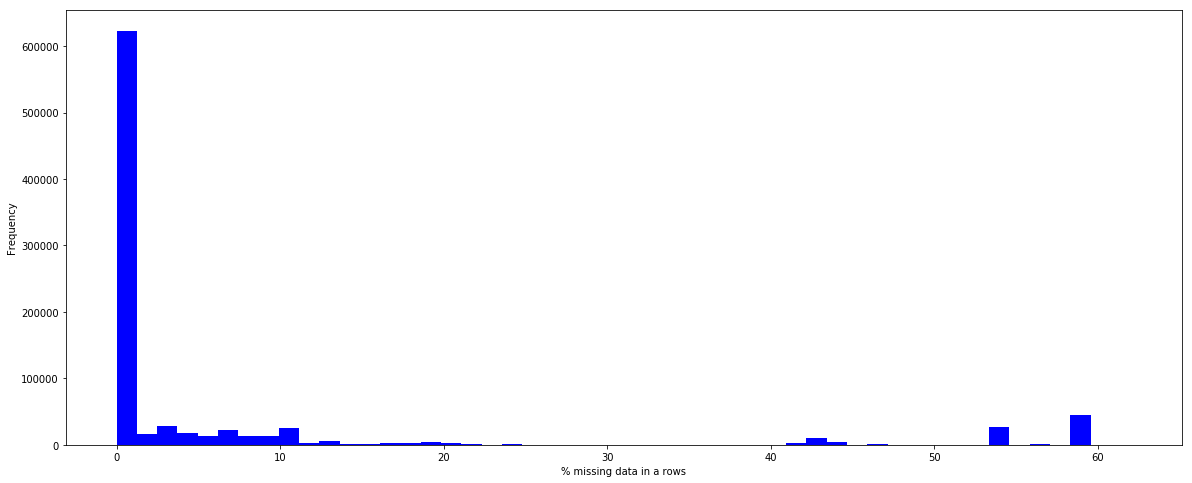

In [31]:
# Visualize counts of number of missing data points by row
plt.figure(figsize=(30,20))
perc_on_features.plot(kind='hist',bins=50,figsize=(20,8),color='blue');
plt.xlabel('% missing data in a rows');

In [32]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

The dataset is divided in a dataset with no missing values and a dataset with missing values.

In [33]:
# add extra column with number of missing values
# in this way we can split the dataset in two parts
azdias['helper'] = azdias.isnull().sum(axis=1)

In [34]:
# Divide dataset
dataset_no_missing_values = azdias[azdias['helper']==0]
dataset_missing_values = azdias[azdias['helper']>0]

In [35]:
dataset_no_missing_values = dataset_no_missing_values.drop(['helper'], axis = 1)
dataset_no_missing_values.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2,5.0,1,5,1,5,4,3,4,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0


In [36]:
dataset_missing_values = dataset_missing_values.drop(['helper'], axis = 1)
dataset_missing_values.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
11,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,3.0,1,6.0,5,3,4,2,4,1,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,3.0,6.0,4.0
13,1.0,2,5.0,1,4,3,5,5,2,1,...,2.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,6.0,4.0


In [37]:
def plot(column):
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    ax = sns.countplot(x = column, data=dataset_no_missing_values)
    plt.title("No missing values");
    plt.subplot(122)
    ax = sns.countplot(x = column, data=dataset_missing_values)
    plt.title("Missing values");

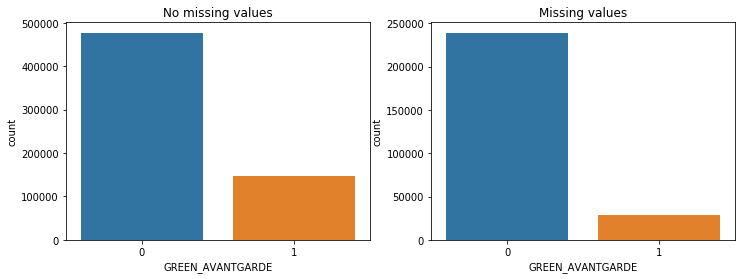

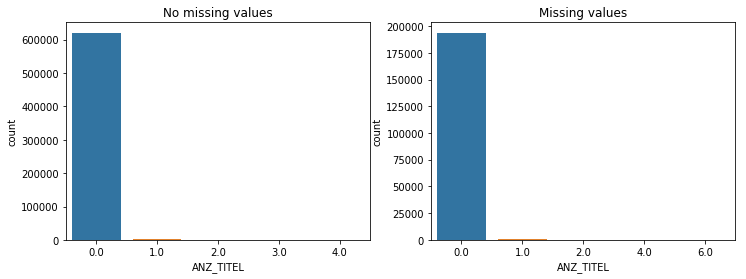

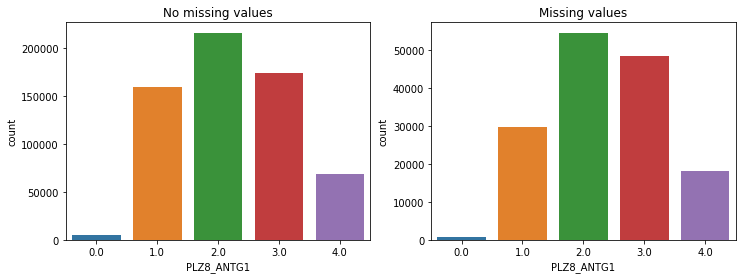

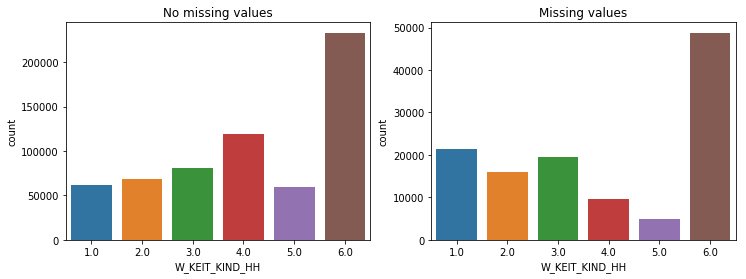

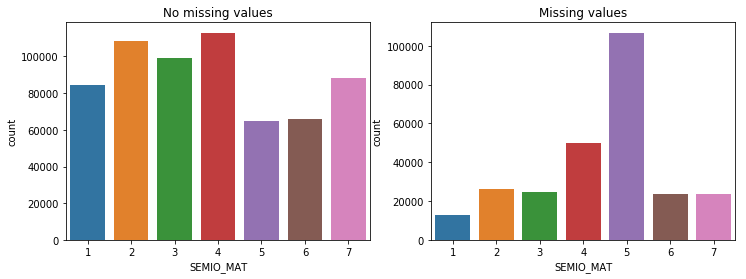

In [38]:
# Take 5 random columns
nmbOfRandomColumns = 5
random_items = random.choices(population=list(dataset_missing_values.columns), k=nmbOfRandomColumns)
random_items

for i in range(nmbOfRandomColumns):
    plot(random_items[i])

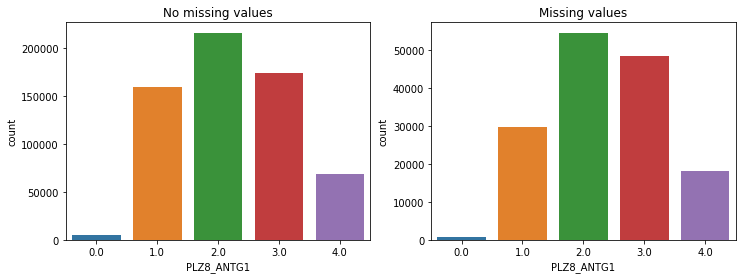

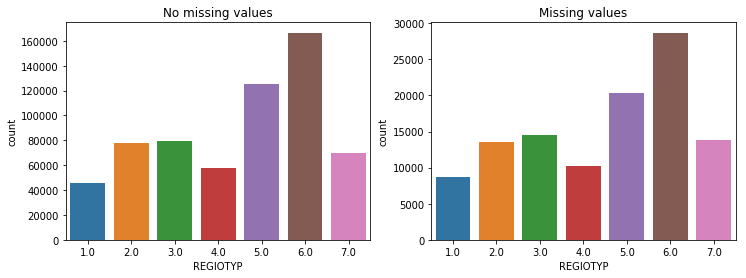

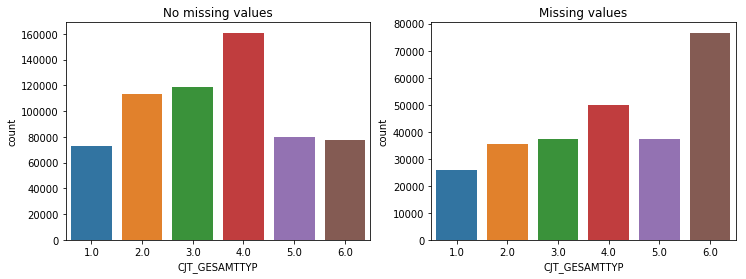

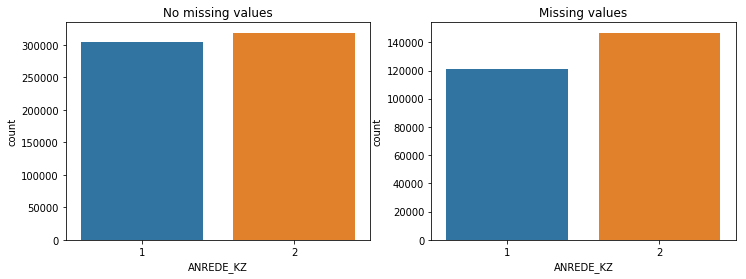

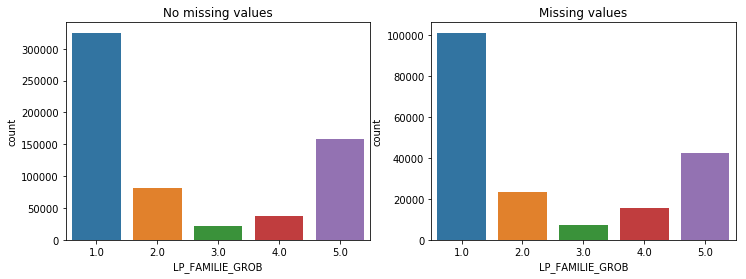

In [39]:
# Take 5 random columns
nmbOfRandomColumns = 5
random_items = random.choices(population=list(dataset_missing_values.columns), k=nmbOfRandomColumns)
random_items

for i in range(nmbOfRandomColumns):
    plot(random_items[i])

In [40]:
#for i in range(dataset_missing_values.shape[1]):
#    plot(list(dataset_missing_values.columns)[i])

In [41]:
print('Number of samples group missing values:',dataset_missing_values.shape[0])
print('Number of samples group no missing values::',dataset_no_missing_values.shape[0])
print('Total number of samples:', dataset_no_missing_values.shape[0]+dataset_missing_values.shape[0])

Number of samples group missing values: 268012
Number of samples group no missing values:: 623209
Total number of samples: 891221


In [42]:
print(dataset_missing_values.shape[0]/(dataset_no_missing_values.shape[0]+dataset_missing_values.shape[0]))
print(dataset_no_missing_values.shape[0]/(dataset_no_missing_values.shape[0]+dataset_missing_values.shape[0]))

0.3007245116531141
0.6992754883468859


#### Discussion 1.1.3: Assess Missing Data in Each Row

Personal I have some questions about this part. 
<br>
<br> The conclusion depends on: 1. which columns the random process will select and 2. how much missing data is taken between the two groups. Here we take a group no missing data versus missing data, but if another selection is done you will see other outcomes.
<br><br>
There is a lot written about which approach to take and how to handle missing data and it is not an exact science. There are two approaches: deletion and imputation. A nice figure can be found on https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4
<br><br>
For further analyse we proceed with the only the group with no missing data and delete all the rows with missing values, which is still 70% of the samples. In my opinion this 70% gives still sufficient samples (623209) in the dataset to proceed.

**The dataset that will be further explored is: *dataset_no_missing_values***

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [43]:
# How many features are there of each data type?
print('In the original dataset we have:')
print(feat_info['type'].value_counts())

In the original dataset we have:
ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64


In [44]:
print('But we have deleted columns:')
feat_info.loc[feat_info['attribute'].isin(list(df1[df1>30].index.values))]

But we have deleted columns:


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
11,GEBURTSJAHR,person,numeric,[0]
40,TITEL_KZ,person,categorical,"[-1,0]"
43,ALTER_HH,household,interval,[0]
47,KK_KUNDENTYP,household,categorical,[-1]
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"


Given the delete colums a new feature info list is made. 

In [45]:
indexList = feat_info.loc[feat_info['attribute'].isin(list(df1[df1>30].index.values))].index
list(indexList)

[0, 11, 40, 43, 47, 64]

In [46]:
new_feat_info = feat_info.drop(feat_info.index[indexList])
print('How many features are there of each data type?')
print(new_feat_info['type'].value_counts())

How many features are there of each data type?
ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64


We have 18 categorical and 6 mixed variable types that needs special handling.

**The new feature list that will be used is: *new_feat_info***

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [47]:
# Build a list of attributes with type categorical
the_categorical_features = new_feat_info[new_feat_info['type'] == 'categorical']['attribute']
the_list_of_categorical_features = list(the_categorical_features)
the_list_of_categorical_features

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [48]:
dataset_no_missing_values[the_list_of_categorical_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623209 entries, 1 to 891220
Data columns (total 18 columns):
ANREDE_KZ           623209 non-null int64
CJT_GESAMTTYP       623209 non-null float64
FINANZTYP           623209 non-null int64
GFK_URLAUBERTYP     623209 non-null float64
GREEN_AVANTGARDE    623209 non-null int64
LP_FAMILIE_FEIN     623209 non-null float64
LP_FAMILIE_GROB     623209 non-null float64
LP_STATUS_FEIN      623209 non-null float64
LP_STATUS_GROB      623209 non-null float64
NATIONALITAET_KZ    623209 non-null float64
SHOPPER_TYP         623209 non-null float64
SOHO_KZ             623209 non-null float64
VERS_TYP            623209 non-null float64
ZABEOTYP            623209 non-null int64
GEBAEUDETYP         623209 non-null float64
OST_WEST_KZ         623209 non-null object
CAMEO_DEUG_2015     623209 non-null object
CAMEO_DEU_2015      623209 non-null object
dtypes: float64(11), int64(4), object(3)
memory usage: 110.3+ MB


In [49]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
binary = []
multi_level = []
for attribute in the_list_of_categorical_features:
    #print(attribute)
    #print(len(dataset_no_missing_values[the_list_of_categorical_features][attribute].value_counts()))
    if len(dataset_no_missing_values[the_list_of_categorical_features][attribute].value_counts()) == 2:
        binary.append(attribute)
    else:
        multi_level.append(attribute)

print('Feature list with binary data:')
print(binary)
print('')
print('Feature list with multi_level data:')
print(multi_level)

Feature list with binary data:
['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

Feature list with multi_level data:
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [50]:
len(binary)

5

In [51]:
len(multi_level)

13

In [52]:
# Re-encode categorical variable(s) to be kept in the analysis.

In [53]:
# Find in binary list the variable that is non-numeric values
for element in binary:
    print(element, dataset_no_missing_values[element].dtypes)

ANREDE_KZ int64
GREEN_AVANTGARDE int64
SOHO_KZ float64
VERS_TYP float64
OST_WEST_KZ object


In [54]:
for element in binary:
    print(element)
    print(dataset_no_missing_values[the_list_of_categorical_features][element].unique())

ANREDE_KZ
[2 1]
GREEN_AVANTGARDE
[0 1]
SOHO_KZ
[1. 0.]
VERS_TYP
[2. 1.]
OST_WEST_KZ
['W' 'O']


OST_WEST_KZ has type object, this is non numeric.

In [55]:
# Re-encode binary data: OST_WEST_KZ
dataset_no_missing_values['OST_WEST_KZ'] = dataset_no_missing_values['OST_WEST_KZ'].map({'W': 1, 'O': 0})
dataset_no_missing_values['OST_WEST_KZ'].head()

1    1
2    1
4    1
5    1
6    1
Name: OST_WEST_KZ, dtype: int64

In [56]:
# Re-encode categorical variable(s) to be kept in the analysis.
for element in multi_level:
    print(element, dataset_no_missing_values[element].dtypes)

CJT_GESAMTTYP float64
FINANZTYP int64
GFK_URLAUBERTYP float64
LP_FAMILIE_FEIN float64
LP_FAMILIE_GROB float64
LP_STATUS_FEIN float64
LP_STATUS_GROB float64
NATIONALITAET_KZ float64
SHOPPER_TYP float64
ZABEOTYP int64
GEBAEUDETYP float64
CAMEO_DEUG_2015 object
CAMEO_DEU_2015 object


In [57]:
for element in multi_level:
    print(element, dataset_no_missing_values[element].unique())

CJT_GESAMTTYP [5. 3. 2. 4. 1. 6.]
FINANZTYP [1 5 2 4 6 3]
GFK_URLAUBERTYP [10.  5.  1. 12.  9.  3.  8. 11.  4.  7.  6.  2.]
LP_FAMILIE_FEIN [ 5.  1. 10.  2.  7. 11.  8.  4.  6.  9.  3.]
LP_FAMILIE_GROB [3. 1. 5. 2. 4.]
LP_STATUS_FEIN [ 2.  3.  4.  1. 10.  9.  5.  6.  7.  8.]
LP_STATUS_GROB [1. 2. 5. 4. 3.]
NATIONALITAET_KZ [1. 2. 3.]
SHOPPER_TYP [3. 2. 0. 1.]
ZABEOTYP [5 4 1 6 3 2]
GEBAEUDETYP [8. 1. 3. 5.]
CAMEO_DEUG_2015 ['8' '4' '6' '2' '1' '9' '5' '7' '3']
CAMEO_DEU_2015 ['8A' '4C' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5D' '9E' '9B' '1B' '8B'
 '7A' '3D' '4E' '3C' '5A' '7B' '9A' '6E' '6D' '2C' '5C' '9C' '7D' '5E'
 '1D' '8D' '6C' '5B' '7C' '4D' '3A' '2B' '7E' '4B' '2A' '3B' '6F' '5F'
 '1C' '6A']


In [58]:
dataset_no_missing_values = pd.get_dummies(dataset_no_missing_values, columns=multi_level)

In [59]:
list(dataset_no_missing_values.columns);

#### Discussion 1.2.1: Re-Encode Categorical Features

There are 18 categorical variables, 5 binary and 13 multilevel. 

- One binary was non-numeric, OST_WEST_KZ, and re-encode to 1 and 0.

- The multi-level variables where all re-encode using the pd.get_dummies method. 

- No categorical features delete.


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [60]:
new_feat_info[new_feat_info['type'] == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [61]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
dataset_no_missing_values['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    144627
8.0     114745
5.0      69527
10.0     68820
3.0      44103
15.0     33585
9.0      29033
11.0     28375
6.0      22802
12.0     19933
4.0      18371
1.0      15233
2.0       6189
13.0      4450
7.0       3416
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [62]:
# interval-type variable for decade
# Build a dict
# 0 = 40  -> 5 = 90
decade_dict = {0: [1, 2], 1: [3, 4], 2: [5, 6, 7], 3: [8, 9], 4: [10, 11, 12, 13], 5:[14, 15]}

# binary variable for movement.
# Build a dict
# 0 = Mainstream - 1 = Avantgarde
movement_dict = {0: [1, 3, 5, 8, 10, 12, 14], 1: [2, 4, 6, 7, 9, 11, 13, 15]}

def map_decade_dict(x):
    for key, value in decade_dict.items():
        if x in value: return key
        
def map_movement_dict(x):
    for key, value in movement_dict.items():
        if x in value: return key

In [63]:
dataset_no_missing_values['PRAEGENDE_JUGENDJAHRE_decade'] = dataset_no_missing_values['PRAEGENDE_JUGENDJAHRE'].apply(map_decade_dict)
dataset_no_missing_values['PRAEGENDE_JUGENDJAHRE_movement'] = dataset_no_missing_values['PRAEGENDE_JUGENDJAHRE'].apply(map_movement_dict)

In [64]:
dataset_no_missing_values['PRAEGENDE_JUGENDJAHRE_decade'].value_counts()

5    178212
3    143778
4    121578
2     95745
1     62474
0     21422
Name: PRAEGENDE_JUGENDJAHRE_decade, dtype: int64

In [65]:
dataset_no_missing_values['PRAEGENDE_JUGENDJAHRE_movement'].value_counts()

0    476988
1    146221
Name: PRAEGENDE_JUGENDJAHRE_movement, dtype: int64

In [66]:
dataset_no_missing_values = dataset_no_missing_values.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1)

In [67]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
dataset_no_missing_values['CAMEO_INTL_2015'].value_counts()

51    111261
41     74647
24     73984
14     48465
43     46538
54     37893
25     30969
22     23899
45     22025
13     19617
55     18638
52     16677
34     15112
23     14693
15     13578
31     12370
44     12060
35      8380
32      8071
33      7432
12      6900
Name: CAMEO_INTL_2015, dtype: int64

In [68]:
wealthy = list(range(11, 16))
prosperous = list(range(21, 26))
comfortable = list(range(31, 36))
less_affluent = list(range(41, 46))
poorer = list(range(51, 56))

wealthy_dict = {0: wealthy, 1: prosperous, 2: comfortable, 3: less_affluent, 4: poorer}
wealthy_dict

{0: [11, 12, 13, 14, 15],
 1: [21, 22, 23, 24, 25],
 2: [31, 32, 33, 34, 35],
 3: [41, 42, 43, 44, 45],
 4: [51, 52, 53, 54, 55]}

In [69]:
def map_wealthy_dict(x):
    for key, value in wealthy_dict.items():
        if int(x) in value: return key
        
dataset_no_missing_values['CAMEO_INTL_2015_wealth'] = dataset_no_missing_values['CAMEO_INTL_2015'].apply(map_wealthy_dict)
dataset_no_missing_values['CAMEO_INTL_2015_wealth'].value_counts() 

4    184469
3    155270
1    143545
0     88560
2     51365
Name: CAMEO_INTL_2015_wealth, dtype: int64

In [70]:
pre_family_couples_singles = list(range(11, 61, 10))
young_couples_with_children = list(range(12, 62, 10))
families_with_school_age_children = list(range(13, 63, 10))
older_families_mature_couples = list(range(14, 64, 10))
elders_in_retirement = list(range(15, 65, 10))

life_stage_dict = {0: pre_family_couples_singles, 1: young_couples_with_children, 2: families_with_school_age_children, 3: older_families_mature_couples, 4: elders_in_retirement}
life_stage_dict

{0: [11, 21, 31, 41, 51],
 1: [12, 22, 32, 42, 52],
 2: [13, 23, 33, 43, 53],
 3: [14, 24, 34, 44, 54],
 4: [15, 25, 35, 45, 55]}

In [71]:
def map_life_stage_dict(x):
    for key, value in life_stage_dict.items():
        if int(x) in value: return key
        
dataset_no_missing_values['CAMEO_INTL_2015_life_stage'] = dataset_no_missing_values['CAMEO_INTL_2015'].apply(map_life_stage_dict)
dataset_no_missing_values['CAMEO_INTL_2015_life_stage'].value_counts() 

0    198278
3    187514
4     93590
2     88280
1     55547
Name: CAMEO_INTL_2015_life_stage, dtype: int64

In [72]:
dataset_no_missing_values = dataset_no_missing_values.drop(['CAMEO_INTL_2015_wealth'], axis=1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

**PRAEGENDE_JUGENDJAHRE**

Two mapping functions where defined to create two new features: generation and movement. The original features are dropped from the dataset.

**CAMEO_INTL_2015**

Two mapping functions are defined to create two new features: wealth and life stage. The original feature are dropped from the dataset.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [73]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [74]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [75]:
decade_dict = {0: [1, 2], 1: [3, 4], 2: [5, 6, 7], 3: [8, 9], 4: [10, 11, 12, 13], 5:[14, 15]}
def map_decade_dict(x):
    for key, value in decade_dict.items():
        if x in value: return key

movement_dict = {0: [1, 3, 5, 8, 10, 12, 14], 1: [2, 4, 6, 7, 9, 11, 13, 15]}
def map_movement_dict(x):
    for key, value in movement_dict.items():
        if x in value: return key

wealthy_dict = {0: [11, 12, 13, 14, 15],
                    1: [21, 22, 23, 24, 25],
                    2: [31, 32, 33, 34, 35],
                    3: [41, 42, 43, 44, 45],
                    4: [51, 52, 53, 54, 55]}
def map_wealthy_dict(x):
    for key, value in wealthy_dict.items():
        if int(x) in value: return key
        
life_stage_dict = {0: [11, 21, 31, 41, 51],
                   1: [12, 22, 32, 42, 52],
                   2: [13, 23, 33, 43, 53],
                   3: [14, 24, 34, 44, 54],
                   4: [15, 25, 35, 45, 55]}

def map_life_stage_dict(x):
    for key, value in life_stage_dict.items():
        if int(x) in value: return key

In [76]:
def clean_data(df, df_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...    
    # remove selected columns and rows, ...    
    # select, re-encode, and engineer column values.
    # Return the cleaned dataframe.
    
    # convert missing value codes into NaNs, ...
    df_features = list(df.columns)
    i = 0
    for element in df_features:
        mylist = df_info.loc[i].missing_or_unknown[1:-1].split(',')
        helper_df = df[df_features[i]].isin(mylist)
        df[element] = df[element].where(helper_df == False)
        i=i+1
    
    # remove selected columns and rows, ... 
    drop_columns = ['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH']
    df.drop(drop_columns, axis = 1, inplace = True)
    
    # build df with no missing values
    df['helper'] = df.isnull().sum(axis=1)
    df_no_missing_values = df[df['helper']==0]
    df_no_missing_values = df_no_missing_values.drop(['helper'], axis = 1)
 
    # select, re-encode, and engineer column values.
    df_no_missing_values['OST_WEST_KZ'] = df_no_missing_values['OST_WEST_KZ'].map({'W': 1, 'O': 0})
    
    multi_level = ['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN','LP_FAMILIE_GROB','LP_STATUS_FEIN','LP_STATUS_GROB','NATIONALITAET_KZ','SHOPPER_TYP','ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015','CAMEO_DEU_2015']
    df_no_missing_values = pd.get_dummies(df_no_missing_values, columns=multi_level)

    df_no_missing_values['PRAEGENDE_JUGENDJAHRE_decade'] = df_no_missing_values['PRAEGENDE_JUGENDJAHRE'].apply(map_decade_dict)
    df_no_missing_values['PRAEGENDE_JUGENDJAHRE_movement'] = df_no_missing_values['PRAEGENDE_JUGENDJAHRE'].apply(map_movement_dict)
    df_no_missing_values = df_no_missing_values.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1)
    
    df_no_missing_values['CAMEO_INTL_2015_wealth'] = df_no_missing_values['CAMEO_INTL_2015'].apply(map_wealthy_dict)
    df_no_missing_values['CAMEO_INTL_2015_life_stage'] = df_no_missing_values['CAMEO_INTL_2015'].apply(map_life_stage_dict)
    df_no_missing_values = df_no_missing_values.drop(['CAMEO_INTL_2015_wealth'], axis=1)

    # Return the cleaned dataframe.
    return df_no_missing_values

In [77]:
df = clean_data(azdias, feat_info)
df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_life_stage
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,0,5,0,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,0,5,1,3
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,0,3,0,2
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1,0,0,0,0,0,0,1,0,3
6,2.0,2,1,5,1,5,4,3,0,2.0,...,0,0,0,0,0,0,0,4,0,1


In [78]:
df.shape

(623209, 193)

In [79]:
# Compare 
df.equals(dataset_no_missing_values)

True

TRUE: both dataframes are the same.

## Load data and clean

In [80]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

decade_dict = {0: [1, 2], 1: [3, 4], 2: [5, 6, 7], 3: [8, 9], 4: [10, 11, 12, 13], 5:[14, 15]}
def map_decade_dict(x):
    for key, value in decade_dict.items():
        if x in value: return key

movement_dict = {0: [1, 3, 5, 8, 10, 12, 14], 1: [2, 4, 6, 7, 9, 11, 13, 15]}
def map_movement_dict(x):
    for key, value in movement_dict.items():
        if x in value: return key

wealthy_dict = {0: [11, 12, 13, 14, 15],
                    1: [21, 22, 23, 24, 25],
                    2: [31, 32, 33, 34, 35],
                    3: [41, 42, 43, 44, 45],
                    4: [51, 52, 53, 54, 55]}
def map_wealthy_dict(x):
    for key, value in wealthy_dict.items():
        if int(x) in value: return key
        
life_stage_dict = {0: [11, 21, 31, 41, 51],
                   1: [12, 22, 32, 42, 52],
                   2: [13, 23, 33, 43, 53],
                   3: [14, 24, 34, 44, 54],
                   4: [15, 25, 35, 45, 55]}

def map_life_stage_dict(x):
    for key, value in life_stage_dict.items():
        if int(x) in value: return key
        
def clean_data(data, data_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...    
    # remove selected columns and rows, ...    
    # select, re-encode, and engineer column values.
    # Return the cleaned dataframe.
    
    # convert missing value codes into NaNs, ...
    data_features = list(data.columns)
    i = 0
    for element in data_features:
        mylist = data_info.loc[i].missing_or_unknown[1:-1].split(',')
        helper_data = data[data_features[i]].isin(mylist)
        data[element] = data[element].where(helper_data == False)
        i=i+1
    
    # remove selected columns and rows, ... 
    drop_columns = ['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH']
    data.drop(drop_columns, axis = 1, inplace = True)
    
    # build df with no missing values
    data['helper'] = data.isnull().sum(axis=1)
    data_no_missing_values = data[data['helper']==0]
    data_no_missing_values = data_no_missing_values.drop(['helper'], axis = 1)
 
    # select, re-encode, and engineer column values.
    data_no_missing_values['OST_WEST_KZ'] = data_no_missing_values['OST_WEST_KZ'].map({'W': 1, 'O': 0})
    
    multi_level = ['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN','LP_FAMILIE_GROB','LP_STATUS_FEIN','LP_STATUS_GROB','NATIONALITAET_KZ','SHOPPER_TYP','ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015','CAMEO_DEU_2015']
    data_no_missing_values = pd.get_dummies(data_no_missing_values, columns=multi_level)

    data_no_missing_values['PRAEGENDE_JUGENDJAHRE_decade'] = data_no_missing_values['PRAEGENDE_JUGENDJAHRE'].apply(map_decade_dict)
    data_no_missing_values['PRAEGENDE_JUGENDJAHRE_movement'] = data_no_missing_values['PRAEGENDE_JUGENDJAHRE'].apply(map_movement_dict)
    data_no_missing_values = data_no_missing_values.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1)
    
    data_no_missing_values['CAMEO_INTL_2015_wealth'] = data_no_missing_values['CAMEO_INTL_2015'].apply(map_wealthy_dict)
    data_no_missing_values['CAMEO_INTL_2015_life_stage'] = data_no_missing_values['CAMEO_INTL_2015'].apply(map_life_stage_dict)
    data_no_missing_values = data_no_missing_values.drop(['CAMEO_INTL_2015_wealth'], axis=1)

    # Return the cleaned dataframe.
    return data_no_missing_values

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [81]:
df = clean_data(azdias, feat_info)
df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_life_stage
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,0,5,0,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,0,5,1,3
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,0,3,0,2
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1,0,0,0,0,0,0,1,0,3
6,2.0,2,1,5,1,5,4,3,0,2.0,...,0,0,0,0,0,0,0,4,0,1


In [82]:
df.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEU_2015_8C', 'CAMEO_DEU_2015_8D', 'CAMEO_DEU_2015_9A',
       'CAMEO_DEU_2015_9B', 'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D',
       'CAMEO_DEU_2015_9E', 'PRAEGENDE_JUGENDJAHRE_decade',
       'PRAEGENDE_JUGENDJAHRE_movement', 'CAMEO_INTL_2015_life_stage'],
      dtype='object', length=193)

In [83]:
list_columns = list(df.columns)

In [84]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

In [85]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[df.columns] = scaler.fit_transform(df[df.columns].as_matrix())

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [86]:
df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_life_stage
1,-1.746291,0.977825,-1.512224,1.581058,-1.045042,1.539058,1.047073,1.340482,-0.553670,1.044647,...,-0.211687,-0.157429,-0.165818,-0.196773,-0.185007,-0.196619,-0.075861,1.164454,-0.553670,-1.251108
2,0.202107,0.977825,-1.512224,0.900443,-1.765051,-0.531628,0.318373,1.340482,1.806129,1.044647,...,-0.211687,-0.157429,-0.165818,-0.196773,-0.185007,-0.196619,-0.075861,1.164454,1.806129,0.749822
4,0.202107,-1.022678,0.692406,0.219828,0.394976,-1.221857,0.318373,-0.856545,-0.553670,1.044647,...,-0.211687,-0.157429,-0.165818,-0.196773,-0.185007,-0.196619,-0.075861,-0.213400,-0.553670,0.082845
5,-1.746291,0.977825,-0.042471,-1.141401,1.114984,-0.531628,-0.410328,1.340482,-0.553670,1.044647,...,4.723964,-0.157429,-0.165818,-0.196773,-0.185007,-0.196619,-0.075861,-1.591253,-0.553670,0.749822
6,-0.772092,0.977825,-1.512224,1.581058,-1.765051,1.539058,1.047073,-0.124203,-0.553670,-0.273496,...,-0.211687,-0.157429,-0.165818,-0.196773,-0.185007,-0.196619,-0.075861,0.475527,-0.553670,-0.584131


### Discussion 2.1: Apply Feature Scaling

All the features were standardized using StandardScaler to achieve a mean of 0 and standard deviation of 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [87]:
# Investigate the variance accounted for by each principal component.
# reference: Udacity course note
def scree_plot(pca):
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s" % ((str(vals[i]*100)[:3])), (ind[i], vals[i]), va="bottom", ha="center", fontsize=4.5)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

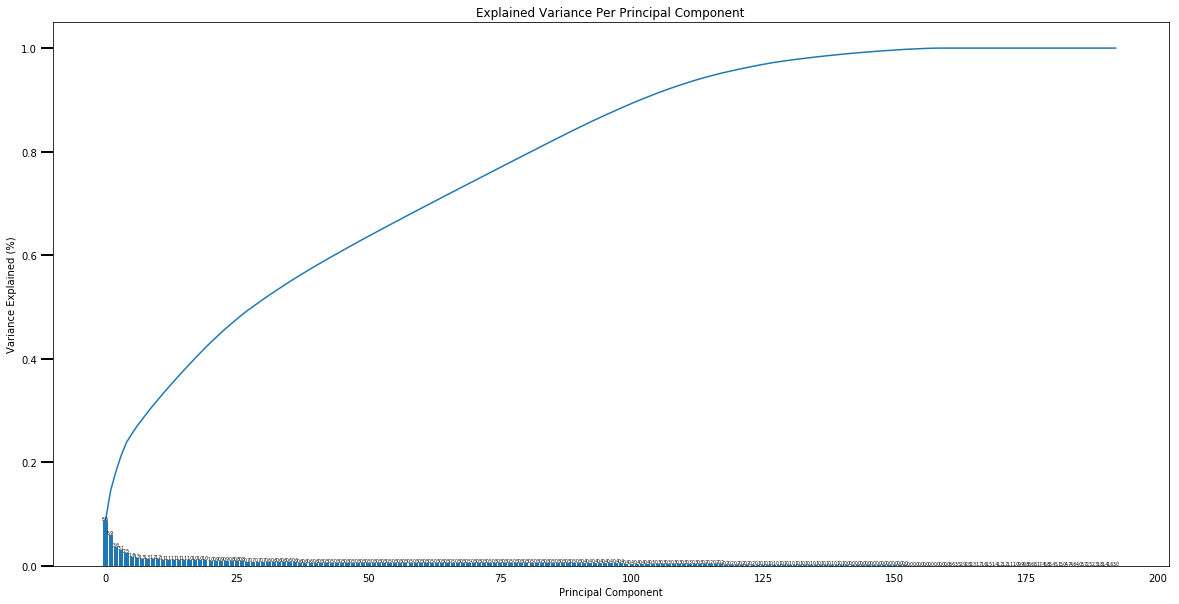

In [88]:
# Apply PCA to the data.
pca = PCA()
pca_df = pca.fit_transform(df)  

scree_plot(pca)

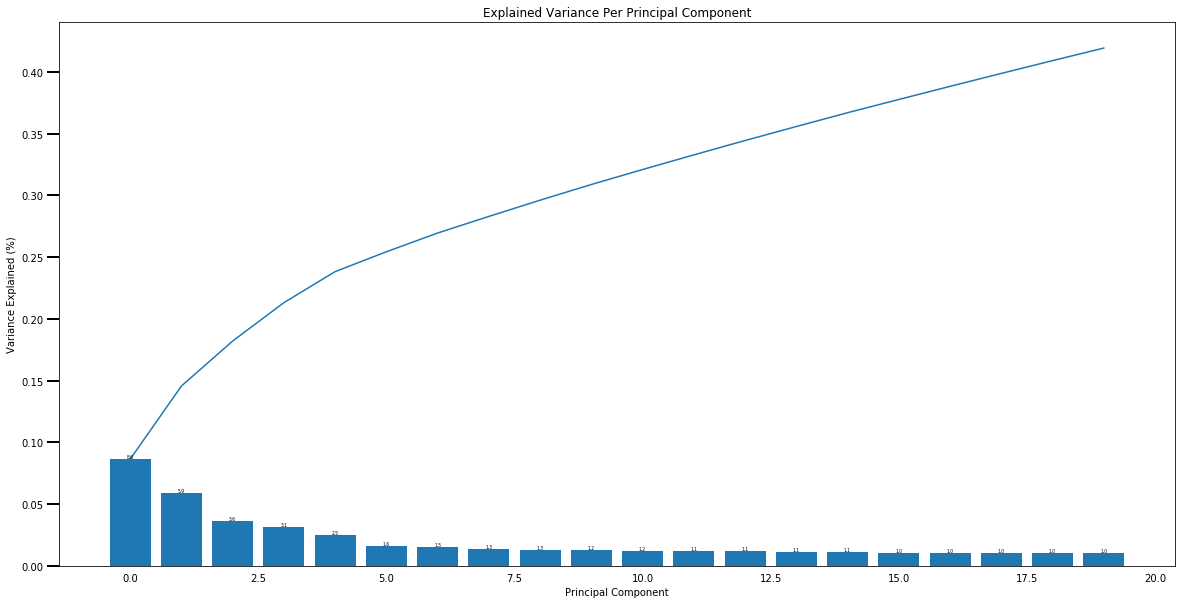

In [89]:
# Re-apply PCA to the data while selecting for number of components to retain.
n_components = 20
pca_n_components = PCA(n_components)
pca_df_n_components = pca_n_components.fit_transform(df)  

scree_plot(pca_n_components)

### Discussion 2.2: Perform Dimensionality Reduction

PCA is applied and the variance explained by each component is studied using the scree plot function. Finally 20 components are selected which gives a a cumulative variance of about 40% of the data.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [90]:
# https://stackoverflow.com/questions/22984335/recovering-features-names-of-explained-variance-ratio-in-pca-with-sklearn
weight = pd.DataFrame(pca_n_components.components_,columns=df.columns)
weight.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_life_stage
0,-0.089233,0.007942,-0.182466,0.112150,-0.086653,0.053390,0.053599,0.136111,-0.106924,0.027945,...,0.031904,0.024580,0.034255,0.055074,0.055404,0.053871,0.013192,0.076367,-0.106924,-0.107442
1,0.233945,0.039700,0.085755,-0.223251,0.212409,-0.199505,-0.210184,0.082781,-0.008705,-0.046363,...,0.015884,0.035127,-0.007372,0.001913,0.006686,0.011543,0.030483,-0.235245,-0.008705,0.007386
2,0.020496,-0.332926,0.130438,-0.052631,0.046597,-0.157803,-0.036755,-0.066881,0.099053,-0.001474,...,-0.008820,-0.001554,-0.004566,0.010173,0.025104,0.010852,0.000051,-0.050577,0.099053,-0.011335
3,-0.007061,0.109436,-0.020272,0.005002,-0.003910,-0.033575,0.022879,0.002111,0.183810,-0.014519,...,0.001412,-0.003157,0.015051,0.003388,0.006226,0.004173,0.003643,0.021354,0.183810,0.003501
4,0.053193,-0.061309,0.017837,-0.026186,0.041512,0.047571,-0.111018,0.017489,-0.228777,-0.003339,...,0.052835,0.034597,0.053161,0.032921,0.015699,0.017788,-0.000116,-0.037355,-0.228777,-0.066419


In [91]:
variance = pd.DataFrame(pca_n_components.explained_variance_ratio_,columns = ['Explained Variance'])
variance.head()

,Explained Variance
0,0.086370
1,0.059257
2,0.036476
3,0.031065
4,0.025157


In [92]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
# Function integrating the steps above to be used in later analysis

def print_weights(principal_component,no_of_weights):
    print('no_of_weights:', no_of_weights)
    print('')
    print('Principal component:',principal_component)
    print('')
    print('highest positive weights')
    print(weight.iloc[principal_component-1].sort_values(ascending=False)[:no_of_weights])
    print('')
    print('highest negative weights')
    print(weight.iloc[principal_component-1].sort_values(ascending=True)[:no_of_weights])

In [93]:
# Analysis of the highest positive and negative weights for the first Principal Componnent
print_weights(1,5)

no_of_weights: 5

Principal component: 1

highest positive weights
LP_STATUS_GROB_1.0    0.186049
HH_EINKOMMEN_SCORE    0.175432
PLZ8_ANTG3            0.174369
CAMEO_INTL_2015       0.171326
PLZ8_ANTG4            0.169342
Name: 0, dtype: float64

highest negative weights
MOBI_REGIO          -0.197778
KBA05_ANTG1         -0.186077
FINANZ_MINIMALIST   -0.182466
PLZ8_ANTG1          -0.176733
KBA05_GBZ           -0.174992
Name: 0, dtype: float64


In [94]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_weights(2,5)

no_of_weights: 5

Principal component: 2

highest positive weights
ALTERSKATEGORIE_GROB    0.233945
FINANZ_VORSORGER        0.212409
ZABEOTYP_3              0.199482
SEMIO_ERL               0.184999
SEMIO_LUST              0.161940
Name: 1, dtype: float64

highest negative weights
PRAEGENDE_JUGENDJAHRE_decade   -0.235245
FINANZ_SPARER                  -0.223251
SEMIO_REL                      -0.220599
SEMIO_PFLICHT                  -0.213326
FINANZ_UNAUFFAELLIGER          -0.210184
Name: 1, dtype: float64


In [95]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_weights(3,5)

no_of_weights: 5

Principal component: 3

highest positive weights
SEMIO_VERT     0.314013
SEMIO_FAM      0.251403
SEMIO_SOZ      0.251154
SEMIO_KULT     0.237544
FINANZTYP_5    0.142089
Name: 2, dtype: float64

highest negative weights
ANREDE_KZ    -0.332926
SEMIO_KAEM   -0.301943
SEMIO_DOM    -0.268312
SEMIO_KRIT   -0.256841
SEMIO_ERL    -0.196077
Name: 2, dtype: float64


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [96]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.    

In [97]:
from sklearn.cluster import KMeans

from sklearn.cluster import KMeans
def get_score(data, nmb_clusters):
    kmeans = KMeans(nmb_clusters)
    model_k = kmeans.fit(data)
    return abs(model_k.score(data))

[1]
[50447779.06633197]
[1, 2]
[50447779.06633197, 42538534.131231315]
[1, 2, 3]
[50447779.06633197, 42538534.131231315, 38879679.410538115]
[1, 2, 3, 4]
[50447779.06633197, 42538534.131231315, 38879679.410538115, 36574912.84033308]
[1, 2, 3, 4, 5]
[50447779.06633197, 42538534.131231315, 38879679.410538115, 36574912.84033308, 34776260.92951165]
[1, 2, 3, 4, 5, 6]
[50447779.06633197, 42538534.131231315, 38879679.410538115, 36574912.84033308, 34776260.92951165, 33561720.413879685]
[1, 2, 3, 4, 5, 6, 7]
[50447779.06633197, 42538534.131231315, 38879679.410538115, 36574912.84033308, 34776260.92951165, 33561720.413879685, 32583777.753083665]
[1, 2, 3, 4, 5, 6, 7, 8]
[50447779.06633197, 42538534.131231315, 38879679.410538115, 36574912.84033308, 34776260.92951165, 33561720.413879685, 32583777.753083665, 31680059.731599744]
[1, 2, 3, 4, 5, 6, 7, 8, 9]
[50447779.06633197, 42538534.131231315, 38879679.410538115, 36574912.84033308, 34776260.92951165, 33561720.413879685, 32583777.753083665, 3168005

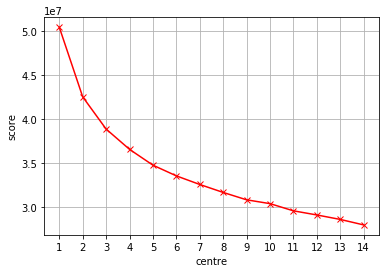

In [98]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
score = []
center = []
nmb_centers = 15

for i in range(1,nmb_centers):
    center.append(i)
    score.append(get_score(pca_df_n_components,i))
    print(center)
    print(score)
    
plt.plot(center, score, linestyle='-', marker='x', color='red')
plt.xlabel('centre')
plt.ylabel('score')
plt.xticks(np.arange(1, nmb_centers, 1))
plt.grid()

In [99]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
k_cluster = 10
kmeans_k_cluster = KMeans(k_cluster)
model_k_cluster = kmeans_k_cluster.fit(pca_df_n_components)
prediction = model_k_cluster.predict(pca_df_n_components)

### Discussion 3.1: Apply Clustering to General Population

The score decrease but there is no clear elbow visible. 
<br>
For further analyse 10 clusters are taken.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [100]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [101]:
customers.columns

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

In [102]:
print('Number of rows (samples):', customers.shape[0])
print('Number of columns:', customers.shape[1])

Number of rows (samples): 191652
Number of columns: 85


In [103]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_new = clean_data(customers, feat_info)

In [104]:
customers_new_columns = list(customers_new.columns)

In [105]:
def diff(first_list, second_list):
    second_list = set(second_list)
    return [item for item in first_list if item not in second_list]

print(diff(list_columns, customers_new_columns))
print(len(list_columns))
print(len(customers_new_columns))

['GEBAEUDETYP_5.0']
193
192


In [106]:
customers['GEBAEUDETYP'].value_counts()

1.0    95145
3.0    23655
8.0    20475
2.0     2057
4.0      251
6.0      142
Name: GEBAEUDETYP, dtype: int64

The Udacity_CUSTOMERS_Subset has no GEBAEUDETYP with value 5. We need to tackle this...

- Step 1: add a row (we copy the last row)
- Step 2: set value in column GEBAEUDETYP last row to 5
- Step 3: clean de the data
- Step 4: remove last row

In [107]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')
customers.head()
customers.tail()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
191647,1,3,1,4.0,5,1,5,1,1,2,...,2.0,4.0,2.0,1.0,2.0,5.0,4.0,3.0,8.0,5.0
191648,-1,4,2,2.0,5,1,5,2,2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,1.0
191649,2,4,1,2.0,5,1,5,1,1,2,...,3.0,2.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0
191650,3,3,2,4.0,2,1,5,1,2,5,...,3.0,2.0,1.0,1.0,1.0,2.0,3.0,3.0,4.0,4.0
191651,3,2,1,2.0,5,1,5,1,1,2,...,3.0,2.0,0.0,0.0,1.0,4.0,5.0,1.0,3.0,1.0


In [108]:
customers_add_row = customers.append(customers.xs(191651), ignore_index=True)
customers_add_row.tail()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
191648,-1,4,2,2.0,5,1,5,2,2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,1.0
191649,2,4,1,2.0,5,1,5,1,1,2,...,3.0,2.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0
191650,3,3,2,4.0,2,1,5,1,2,5,...,3.0,2.0,1.0,1.0,1.0,2.0,3.0,3.0,4.0,4.0
191651,3,2,1,2.0,5,1,5,1,1,2,...,3.0,2.0,0.0,0.0,1.0,4.0,5.0,1.0,3.0,1.0
191652,3,2,1,2.0,5,1,5,1,1,2,...,3.0,2.0,0.0,0.0,1.0,4.0,5.0,1.0,3.0,1.0


In [109]:
customers_add_row.loc[191652,'GEBAEUDETYP'] = 5.0

In [110]:
customers_add_row['GEBAEUDETYP'].value_counts()

1.0    95145
3.0    23655
8.0    20475
2.0     2057
4.0      251
6.0      142
5.0        1
Name: GEBAEUDETYP, dtype: int64

In [111]:
customers.columns

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

In [112]:
customers_new = clean_data(customers_add_row, feat_info)

In [113]:
customers_new = customers_new[:-1]

In [114]:
customers_new.tail()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_life_stage
191646,2.0,2,2,1,5,1,2,5,0,2.0,...,0,0,0,0,0,0,0,3,0,3
191647,3.0,1,5,1,5,1,1,2,1,3.0,...,0,0,0,0,0,0,0,1,1,3
191649,4.0,1,5,1,5,1,1,2,1,2.0,...,0,0,0,0,0,0,0,1,1,3
191650,3.0,2,2,1,5,1,2,5,0,2.0,...,0,0,0,0,0,0,0,3,0,3
191651,2.0,1,5,1,5,1,1,2,0,2.0,...,0,0,0,0,0,0,0,1,0,2


In [115]:
# Sanit check
customers_new_columns = list(customers_new.columns)
print(diff(list_columns, customers_new_columns))
print(len(list_columns))
print(len(customers_new_columns))

[]
193
193


In [116]:
# Scaling
scaler = StandardScaler()
customers_new[customers_new.columns] = scaler.fit_transform(customers_new[customers_new.columns].as_matrix())

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [117]:
customers_new_pca = pca_n_components.transform(customers_new)
customers_new_predict = model_k_cluster.predict(customers_new_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [118]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

In [119]:
nmb_clusters = k_cluster
nmb_clusters

10

In [120]:
general_cluster = pd.Series(prediction)
customer_cluster = pd.Series(customers_new_predict)

In [121]:
general_cluster_prop = pd.Series(100*general_cluster.value_counts().sort_index()/len(general_cluster))
customer_cluster_prop = pd.Series(100*customer_cluster.value_counts().sort_index()/len(customer_cluster))

# Create dataframe 
general_customer_df = pd.concat([general_cluster_prop, customer_cluster_prop], axis=1).reset_index()
general_customer_df.columns = ['cluster','general','customer']
general_customer_df

,cluster,population,customer
0,0,9.154393,8.523646
1,1,9.661606,3.816055
2,2,11.681795,9.466202
3,3,13.368709,14.341551
4,4,7.277013,12.409744
5,5,11.839367,4.351323
6,6,13.104272,14.086456
7,7,4.360495,6.634210
8,8,8.171256,16.489541
9,9,11.381094,9.881273


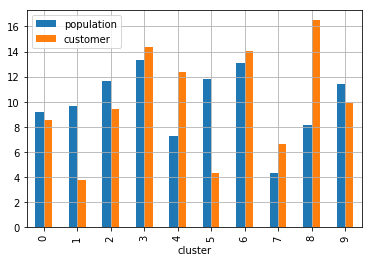

In [122]:
general_customer_df.plot(x="cluster", y=["general", "customer"], kind="bar")
plt.grid()

In [133]:
delta = ((customer_cluster.value_counts().sort_index()/len(customer_cluster))-(general_cluster.value_counts().sort_index()/len(general_cluster)))
delta

0   -0.006307
1   -0.058456
2   -0.022156
3    0.009728
4    0.051327
5   -0.074880
6    0.009822
7    0.022737
8    0.083183
9   -0.014998
dtype: float64

In [134]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
cluster_PCA_overrepresented = 8

PCA_overrepresented = pd.Series(kmeans_k_cluster.cluster_centers_[cluster_PCA_overrepresented])
PCA_overrepresented.index = PCA_overrepresented.index+1
PCA_overrepresented.sort_values(ascending=False)

4     3.561503
3     1.063411
12    0.269756
16    0.186029
14    0.127598
9     0.051841
19   -0.034848
13   -0.046515
17   -0.193838
7    -0.225137
18   -0.230812
20   -0.334936
15   -0.417312
10   -0.579804
5    -0.732086
8    -0.830945
11   -0.918072
2    -0.941129
6    -1.046241
1    -5.213389
dtype: float64

In [135]:
print_weights(4,5)

no_of_weights: 5

Principal component: 4

highest positive weights
LP_LEBENSPHASE_GROB               0.239469
LP_LEBENSPHASE_FEIN               0.236101
ANZ_PERSONEN                      0.214215
LP_FAMILIE_GROB_5.0               0.209974
PRAEGENDE_JUGENDJAHRE_movement    0.183810
Name: 3, dtype: float64

highest negative weights
LP_FAMILIE_FEIN_1.0   -0.236560
LP_FAMILIE_GROB_1.0   -0.236560
W_KEIT_KIND_HH        -0.164565
WOHNLAGE              -0.163617
INNENSTADT            -0.146214
Name: 3, dtype: float64


In [136]:
PCA_overrepresented_transform = scaler.inverse_transform(pca_n_components.inverse_transform(PCA_overrepresented))
PCA_overrepresented_transform = pd.Series(PCA_overrepresented_transform).round(0)
PCA_overrepresented_transform.index = customers_new_columns
PCA_overrepresented_transform;

In [137]:
print('LP_LEBENSPHASE_GROB ',PCA_overrepresented_transform['LP_LEBENSPHASE_GROB'])
print('LP_LEBENSPHASE_FEIN', PCA_overrepresented_transform['LP_LEBENSPHASE_FEIN'])
print('ANZ_PERSONEN ',PCA_overrepresented_transform['ANZ_PERSONEN'])
print('LP_FAMILIE_GROB_5.0', PCA_overrepresented_transform['LP_FAMILIE_GROB_5.0'])
print('GREEN_AVANTGARDE ',PCA_overrepresented_transform['GREEN_AVANTGARDE'])

print('LP_FAMILIE_FEIN_1.0', PCA_overrepresented_transform['LP_FAMILIE_FEIN_1.0'])
print('LP_FAMILIE_GROB_1.0 ',PCA_overrepresented_transform['LP_FAMILIE_GROB_1.0'])
print('W_KEIT_KIND_HH', PCA_overrepresented_transform['W_KEIT_KIND_HH'])
print('WOHNLAGE', PCA_overrepresented_transform['WOHNLAGE'])
print('INNENSTADT', PCA_overrepresented_transform['INNENSTADT'])

LP_LEBENSPHASE_GROB  13.0
LP_LEBENSPHASE_FEIN 43.0
ANZ_PERSONEN  4.0
LP_FAMILIE_GROB_5.0 1.0
GREEN_AVANTGARDE  1.0
LP_FAMILIE_FEIN_1.0 -0.0
LP_FAMILIE_GROB_1.0  -0.0
W_KEIT_KIND_HH 3.0
WOHNLAGE 3.0
INNENSTADT 5.0


In [138]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
cluster_underrepresented = 5

PCA_underrepresented = pd.Series(kmeans_k_cluster.cluster_centers_[cluster_underrepresented])
PCA_underrepresented.index = PCA_overrepresented.index +1
PCA_underrepresented.sort_values(ascending=False)[:1]

2    4.8128
dtype: float64

In [139]:
print_weights(2,5)

no_of_weights: 5

Principal component: 2

highest positive weights
ALTERSKATEGORIE_GROB    0.233945
FINANZ_VORSORGER        0.212409
ZABEOTYP_3              0.199482
SEMIO_ERL               0.184999
SEMIO_LUST              0.161940
Name: 1, dtype: float64

highest negative weights
PRAEGENDE_JUGENDJAHRE_decade   -0.235245
FINANZ_SPARER                  -0.223251
SEMIO_REL                      -0.220599
SEMIO_PFLICHT                  -0.213326
FINANZ_UNAUFFAELLIGER          -0.210184
Name: 1, dtype: float64


In [140]:
PCA_underrepresented_transform = scaler.inverse_transform(pca_n_components.inverse_transform(PCA_underrepresented))
PCA_underrepresented_transform = pd.Series(PCA_underrepresented_transform).round(0)
PCA_underrepresented_transform.index = customers_new_columns
PCA_underrepresented_transform;

In [141]:
print('ALTERSKATEGORIE_GROB ',PCA_underrepresented_transform['ALTERSKATEGORIE_GROB'])
print('FINANZ_VORSORGER ', PCA_underrepresented_transform['FINANZ_VORSORGER'])
print('ZABEOTYP_3 ',PCA_underrepresented_transform['ZABEOTYP_3'])
print('SEMIO_ERL', PCA_underrepresented_transform['SEMIO_ERL'])
print('SEMIO_LUST ',PCA_underrepresented_transform['SEMIO_LUST'])

print('PRAEGENDE_JUGENDJAHRE_decade', PCA_underrepresented_transform['PRAEGENDE_JUGENDJAHRE_decade'])
print('FINANZ_SPARER ',PCA_underrepresented_transform['FINANZ_SPARER'])
print('SEMIO_REL', PCA_underrepresented_transform['SEMIO_REL'])
print('SEMIO_PFLICHT', PCA_underrepresented_transform['SEMIO_PFLICHT'])
print('FINANZ_UNAUFFAELLIGER', PCA_underrepresented_transform['FINANZ_UNAUFFAELLIGER'])

ALTERSKATEGORIE_GROB  3.0
FINANZ_VORSORGER  4.0
ZABEOTYP_3  0.0
SEMIO_ERL 5.0
SEMIO_LUST  4.0
PRAEGENDE_JUGENDJAHRE_decade 3.0
FINANZ_SPARER  2.0
SEMIO_REL 4.0
SEMIO_PFLICHT 4.0
FINANZ_UNAUFFAELLIGER 3.0


### Discussion 3.3: Compare Customer Data to Demographics Data



By comparing the customer data to demographics data, we can obtain an idea who are the customers are.

The analyse reveal following important features:

- LP_LEBENSPHASE_GROB  13.0
    - high-income earners of higher age from multiperson households
- LP_LEBENSPHASE_FEIN 43.0
    - top earners at retirement age from multiperson household
- ANZ_PERSONEN  4.0
    - Number of adults in household
- LP_FAMILIE_GROB_5.0 1.0
    - multiperson household (maps to 9-11 in fine scale)
- GREEN_AVANTGARDE  1.0
- LP_FAMILIE_FEIN_1.0 -0.0
    - member of green avantgarde
- LP_FAMILIE_GROB_1.0  -0.0
    - single family type
- W_KEIT_KIND_HH 3.0
    - Likelihood of children in household: likely
- WOHNLAGE 3.0
    - average neighborhood
- INNENSTADT 5.0
    - 10 - 20 km to city center



*Customers are high income earners of higher age, mostly retired, from multiperson household (mostly 2 adult children) living in average neighborhood about 10 - 20 km from the city center.* 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

# [EOF]